In [1]:

import sys, os
import imp
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np
sys.path.insert(0,'./lib')
import sims_reader as timean
import timeit
import glob
from sims_reader import (FileManager, MemoryReader, FilterList, Simulation, Sim0404)
from correlations import CorrelateTwoShears

In [2]:
def print_sims(path,param_filter):
    sims = {}
    print('| id | commit | Status | Nodes | Seed | Version | Template | Factor | Shear | Nside | Memory (GB) | Disk  | Time (s)| Preparation Date')
    print(' |:---:|:----:|:----:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:----:|:----:|')
 
    # Delete empty directories
    FileManager.remove_empty_dirs(path)

    # Find simulations
    for i,sim in enumerate(FileManager.get_simulations(path,param_filter)):
        simname = i
        sims[simname] = Sim0404(sim,simname)
    
    # Getting informations    
    for x in sims.keys():
        if sims[x].status == 'done': 
            sims[x].set_time_reader()
            
        sims[x].set_memory_reader()
        sims[x].set_size()
        sims[x].set_shear_reader()
        
    for sim in sims.items():#sorted(sims.items(), key = lambda x: ('0' if x[1].template=='master_with_shear' else x[1].__name__)):
        x = sim[1]
        total_time = round(x.time_reader.times["Total"]/1000 if x.status == 'done' else 0,4)
        print('| {} | {} | {} | {} | {} | {} | {} | {} | {} | {} | {} | {} | {} | {} |'.format(x.__name__,x.commit,x.status,x.nodes,x.seed,x.version,x.template,x.factor,x.shear,x.nside,x.memory_reader.tasks['Total']['Memory']/1000, x.size,total_time, x.preparation_time))
    return sims

In [3]:
import logging.config
logging.basicConfig(stream=sys.stdout, level=logging.WARNING)

In [4]:
path = "/global/cscratch1/sd/cramirez/CoLoRe_LSST/"

In [5]:
filt = {
    "status" : ["done"],
    "template": ["master_with_shear"],
    "factor" : [0.1,0.01]
}

sims = print_sims(path,filt)

| id | commit | Status | Nodes | Seed | Version | Template | Factor | Shear | Nside | Memory (GB) | Disk  | Time (s)| Preparation Date
 |:---:|:----:|:----:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:----:|:----:|
| 0 | 0404 | done | 10 | 1003 | Old | master_with_shear | 0.01 | 5 | 512 | 773.214 | 7.1G | 789.9322 | 202004150834 |
| 1 | 0404 | done | 10 | 1003 | Old | master_with_shear | 0.1 | 5 | 512 | 796.543 | 22G | 1588.4456 | 202004150835 |
| 2 | None | done | 10 | 1003 | master | master_with_shear | 0.01 | None | None | 773.214 | 7.1G | 724.2633 | 20200416090110 |
| 3 | 2005 | done | 10 | 1003 | New | master_with_shear | 0.1 | 20 | 512 | 797.242 | 22G | 694.667 | 20200521010157 |
| 4 | 2005 | done | 10 | 1003 | New | master_with_shear | 0.01 | 20 | 512 | 773.922 | 7.1G | 677.6237 | 20200522145442 |
| 5 | 2005 | done | 10 | 1003 | New | master_with_shear | 0.01 | 5 | 512 | 773.395 | 7.1G | 685.0769 | 20200522152308 |
| 6 | 2005 | done | 10 | 1003 | New | master_with_she

In [6]:
master_old = sims[2]
master = sims[14]
old = sims[13]
new_50 = sims[6]
new_100 = sims[10]
new_50_1024 = sims[9]
old_older_commit = sims[0]

In [7]:
master.location

'/global/cscratch1/sd/cramirez/CoLoRe_LSST/master/0.01/20200525072333'

In [8]:
old.location

'/global/cscratch1/sd/cramirez/CoLoRe_LSST/Old/shear_100/nside_512/0.01/20200524164137'

# Check cl_test

In [9]:
def plotpower(ld,values,labels=None, colors=None, lw=2,
              ylabel='$C_{\\ell \mathrm{new}}/C_{\\ell \mathrm{old}}$', 
              legend = False, legloc = "lower left", legframeon = False, leglabelspacing = 0.1, legncol = 2,
              xlim=[2,192], ylim = None,
               filename="", title ="",path_save_figures=""):
        
    plt.figure()
    if labels is None: labels = [''  for i in range(len(values))]
        
    if colors is not None:
        for i in range(len(values)):
            plt.plot(ld,values[i], colors[i]+'-', lw=lw,
                     label=labels[i])
    else:
        for i in range(len(values)):
            plt.plot(ld,values[i],lw=lw, label = labels[i])
    plt.xlabel('$\\ell$', fontsize=16)
    plt.ylabel(ylabel)
    plt.xlim(xlim)
    if ylim is not None:
        plt.ylim(ylim)
    if legend: plt.legend(loc=legloc, frameon=legframeon, labelspacing=leglabelspacing, ncol=legncol)
    if title != "":
        plt.title(title)
    if filename != "":
        plt.savefig(path_save_figures+filename+'.png',format='png')

In [10]:
cld_dd_string = '$\\delta_g\\times\\delta_g$'
cld_de_string = '$\\gamma^E_g\\times\\delta_g$'
cld_ee_string = '$\\gamma^E_g\\times\\gamma^E_g$'
cld_bb_string = '$\\gamma^B_g\\times\\gamma^B_g$'
cld_eb_string = '$\\gamma^E_g\\times\\gamma^B_g$'
cld_db_string = '$\\gamma^B_g\\times\\delta_g$'
cld_kd_string = '$\\kappa-\\delta_g$'
cld_kk_string = '$\\kappa-\\kappa$'
strings = ['cld_dd','cld_ee','cld_de','cld_bb']
labels = [cld_dd_string, cld_ee_string,cld_de_string,cld_bb_string]
colors = ['r','y','c','m']

In [20]:
master.shear_reader.get_values('ld',source=2, do_cls=True,compute=True) 
master_old.shear_reader.get_values('ld',source=2, do_cls=True,compute=True) 
new_50.shear_reader.get_values('ld',source=2, do_cls=True,compute=True) 
old_older_commit.shear_reader.get_values('ld',source=2, do_cls=True,compute=True) 
old.shear_reader.get_values('ld',source=2, do_cls=True,compute=True) 

array([0.000e+00, 1.000e+00, 2.000e+00, ..., 1.533e+03, 1.534e+03,
       1.535e+03])

In [21]:
ld       = new_50.shear_reader.get_values('ld',source=2)
values   = [new_50.shear_reader.get_values(string,source=2)/old.shear_reader.get_values(string,source=2) for string in strings]
values_1 = [old.shear_reader.get_values(string,source=2)/master.shear_reader.get_values(string,source=2,compute=True) for string in strings]
values_2 = [old.shear_reader.get_values(string,source=2)/old_older_commit.shear_reader.get_values(string,source=2,compute=True) for string in strings]
values_3 = [master_old.shear_reader.get_values(string,source=2)/master.shear_reader.get_values(string,source=2,compute=True) for string in strings]

<ipython-input-21-1a302ec91373>:2: RuntimeWarning: invalid value encountered in true_divide
  values   = [new_50.shear_reader.get_values(string,source=2)/old.shear_reader.get_values(string,source=2) for string in strings]
<ipython-input-21-1a302ec91373>:3: RuntimeWarning: invalid value encountered in true_divide
  values_1 = [old.shear_reader.get_values(string,source=2)/master.shear_reader.get_values(string,source=2,compute=True) for string in strings]
<ipython-input-21-1a302ec91373>:4: RuntimeWarning: invalid value encountered in true_divide
  values_2 = [old.shear_reader.get_values(string,source=2)/old_older_commit.shear_reader.get_values(string,source=2,compute=True) for string in strings]
<ipython-input-21-1a302ec91373>:5: RuntimeWarning: invalid value encountered in true_divide
  values_3 = [master_old.shear_reader.get_values(string,source=2)/master.shear_reader.get_values(string,source=2,compute=True) for string in strings]


(0.99, 1.01)

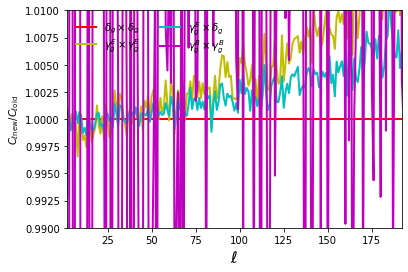

In [13]:
plotpower(ld,values,labels=labels,colors=colors,legend=True,legloc='upper left')
plt.ylim(0.99,1.01)

(0.5, 1.5)

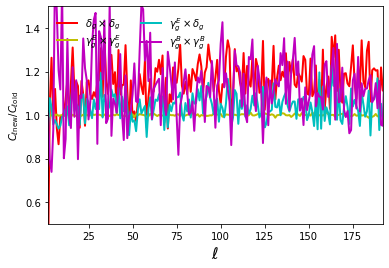

In [17]:
plotpower(ld,values_1,labels=labels,colors=colors,legend=True,legloc='upper left')
plt.ylim(0.5,1.5)

(0.8, 1.2)

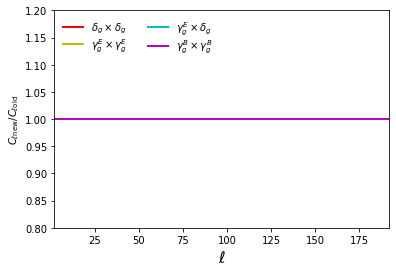

In [18]:
plotpower(ld,values_2,labels=labels,colors=colors,legend=True,legloc='upper left')
plt.ylim(0.8,1.2)

(0.8, 1.2)

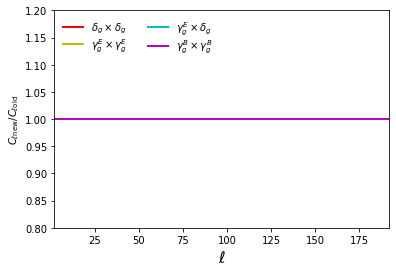

In [22]:
plotpower(ld,values_3,labels=labels,colors=colors,legend=True,legloc='upper left')
plt.ylim(0.8,1.2)

In [ ]:
new_50.get_values('')

In [ ]:
a = old.shear_reader.get_values('mp_e1',source=2,do_cls=True,compute=True)

# nside 512

In [15]:
new_100.shear_reader.location

'/global/cscratch1/sd/cramirez/CoLoRe_LSST/New/shear_100/nside_512/0.01/20200524154935'

In [9]:
correla = CorrelateTwoShears([new_50],[old])
correlb = CorrelateTwoShears([new_100],[old])
correlc = CorrelateTwoShears([old],[master])
correld = CorrelateTwoShears([new_50_1024],[old])

In [10]:
correla.correlation_in_bin(source=2,minz=0,maxz=0.25)

0.9983286785662502

In [11]:
x_values = []
a_values = []
b_values = []
c_values = []
d_values = []

for b in range(10):
    minz = 0 + b*0.25
    maxz = 0 + (1+b)*0.25
    
    x_values.append((maxz+minz)/2)
    print('b:',b)
    a_values.append( correla.correlation_in_bin(source=2,minz=minz,maxz=maxz))
    b_values.append( correlb.correlation_in_bin(source=2,minz=minz,maxz=maxz))
#     c_values.append( correlc.correlation_in_bin(source=2,minz=minz,maxz=maxz))
#     d_values.append( correld.correlation_in_bin(source=2,minz=minz,maxz=maxz))

b: 0
b: 1
b: 2
b: 3
b: 4
b: 5
b: 6
b: 7
b: 8
b: 9


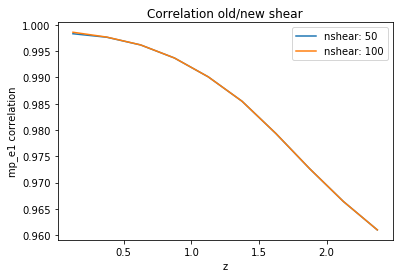

In [12]:
plt.plot(x_values,a_values, label='nshear: 50')
plt.plot(x_values,b_values, label='nshear: 100')
# plt.plot(x_values,c_values, label='Old vs Master')
# plt.plot(x_values,d_values, label='New (50)_1024 vs Old')
plt.title('Correlation old/new shear')
plt.legend()

plt.xlabel('z')
plt.ylabel('mp_e1 correlation')
plt.savefig('bble_.png',dpi=100)
plt.show()

In [13]:
a_values

[0.9983286785662502,
 0.9976654218885662,
 0.9961989478121595,
 0.9937143805765059,
 0.9901241124122866,
 0.9854753668469942,
 0.9793396129393978,
 0.9726273107113476,
 0.9663743172624253,
 0.9609761374066299]

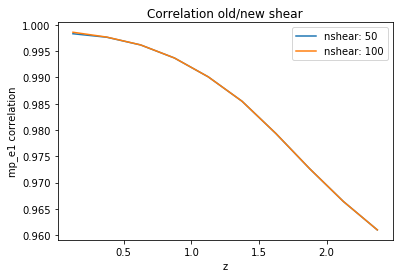

In [20]:

plt.plot(x_values,a_values, label='nshear: 50')
plt.plot(x_values,b_values, label='nshear: 100')
# plt.plot(x_values,c_values, label='Old vs Master')
# plt.plot(x_values,d_values, label='New (50)_1024 vs Old')
plt.title('Correlation old/new shear')
plt.legend()

plt.xlabel('z')
plt.ylabel('mp_e1 correlation')
plt.savefig('bble_.png',dpi=100)
plt.show()

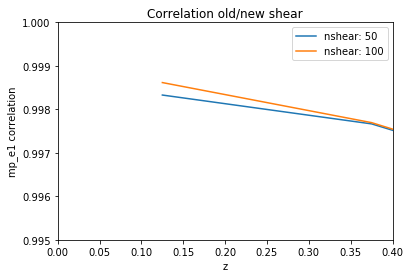

In [22]:

plt.plot(x_values,a_values, label='nshear: 50')
plt.plot(x_values,b_values, label='nshear: 100')
# plt.plot(x_values,c_values, label='Old vs Master')
# plt.plot(x_values,d_values, label='New (50)_1024 vs Old')
plt.title('Correlation old/new shear')
plt.legend()
plt.xlim([0,0.4])
plt.ylim([0.995,1])
plt.xlabel('z')
plt.ylabel('mp_e1 correlation')
plt.savefig('bble_.png',dpi=100)
plt.show()

In [ ]:
plt.plot(x_values,a_values, label='New (50) vs Old')
plt.plot(x_values,b_values, label='New (100) vs Old')
plt.legend()
plt.title('New nshear 50 vs new nshear 100')
plt.show()

In [ ]:
plt.plot(x_values,a_values, label='New (50) vs Old')
plt.plot(x_values,b_values, label='New (100) vs Old')
plt.plot(x_values,d_values, label='New (50)_1024 vs Old')
plt.ylim(0.96,1.02)
plt.legend()
plt.show()

# Old vs Master issues

In [13]:
old_older_commit = sims[10]

In [14]:
old_older_commit.location

'/global/cscratch1/sd/cramirez/CoLoRe_LSST/Old/shear_5/nside_512/0.01/202004150834'

In [29]:
old_older_mp1 = old_older_commit.shear_reader.get_values('mp_e1',source=2,compute=True)

In [10]:
import healpy as hp

In [9]:
master_mp1 = master.shear_reader.get_values('mp_e1',source=2,compute=True)
old_mp1 = old.shear_reader.get_values('mp_e1',source=2,compute=True)
ratio = old_mp1/master_mp1
hp.mollview(ratio,title=None, unit = '$e_{1_{old}}/e_{1_{new}} -1$')

NameError: name 'hp' is not defined

In [35]:
ratio = np.abs(old_mp1/master_mp1)

In [56]:
ratio[ratio>2]=1
ratio[ratio<0.5] = 1

In [57]:
(ratio==1).sum()

520951

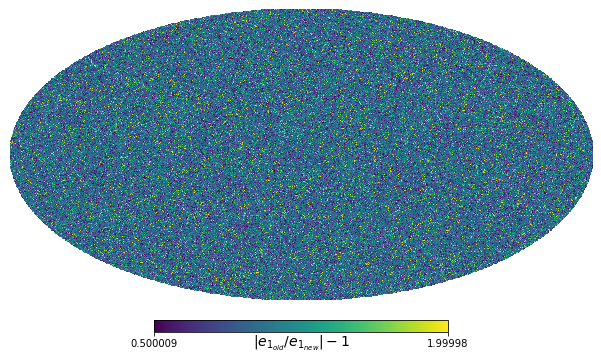

In [58]:
hp.mollview(ratio,title=None, unit = '$|e_{1_{old}}/e_{1_{new}}| -1$')

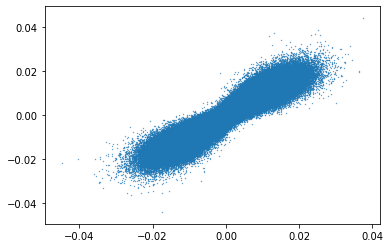

In [21]:
plt.scatter(master_mp1, old_mp1, s=0.1)

In [19]:
glob.glob(master.location + '/data_treated/binned/*/*')

['/global/cscratch1/sd/cramirez/CoLoRe_LSST/master/0.01/20200416090110/data_treated/binned/75_100/source_2',
 '/global/cscratch1/sd/cramirez/CoLoRe_LSST/master/0.01/20200416090110/data_treated/binned/225_250/source_2',
 '/global/cscratch1/sd/cramirez/CoLoRe_LSST/master/0.01/20200416090110/data_treated/binned/200_225/source_2',
 '/global/cscratch1/sd/cramirez/CoLoRe_LSST/master/0.01/20200416090110/data_treated/binned/150_175/source_2',
 '/global/cscratch1/sd/cramirez/CoLoRe_LSST/master/0.01/20200416090110/data_treated/binned/175_200/source_2',
 '/global/cscratch1/sd/cramirez/CoLoRe_LSST/master/0.01/20200416090110/data_treated/binned/100_125/source_2',
 '/global/cscratch1/sd/cramirez/CoLoRe_LSST/master/0.01/20200416090110/data_treated/binned/0_25/source_2',
 '/global/cscratch1/sd/cramirez/CoLoRe_LSST/master/0.01/20200416090110/data_treated/binned/50_75/source_2',
 '/global/cscratch1/sd/cramirez/CoLoRe_LSST/master/0.01/20200416090110/data_treated/binned/125_150/source_2',
 '/global/cscrat

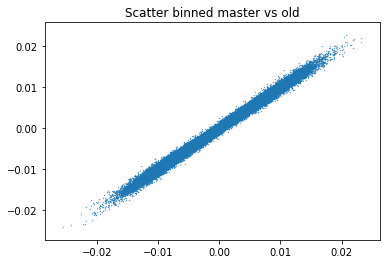

In [11]:
minz = 2.25
maxz = 2.50
a = old.shear_reader.get_values('mp_e1',source=2)
b = master.shear_reader.get_values('mp_e1',source=2)

plt.scatter(a,b, s=0.1)
plt.title('Scatter binned master vs old')
plt.show()

In [12]:
a/b

array([1.15734036, 0.8444567 , 0.86157765, ..., 0.99658066, 1.71568966,
       0.90281118])

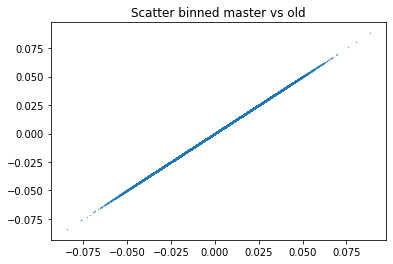

In [15]:
minz = 2.25
maxz = 2.50
a = old.shear_reader.get_values('mp_e1',source=2, minz=minz, maxz=maxz)
b = old_older_commit.shear_reader.get_values('mp_e1',source=2,minz=minz,maxz=maxz)

plt.scatter(a,b, s=0.1)
plt.title('Scatter binned master vs old')
plt.show()

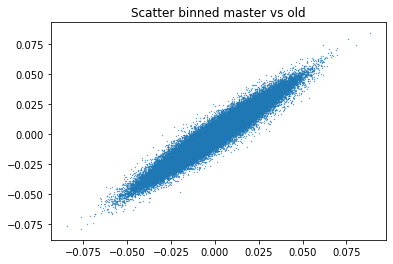

In [39]:
minz = 2.25
maxz = 2.5
a = old.shear_reader.get_values('mp_e1',source=2, minz=minz, maxz=maxz)
b = new_50.shear_reader.get_values('mp_e1',source=2,minz=minz,maxz=maxz)

plt.scatter(a,b, s=0.1)
plt.title('Scatter binned master vs old')
plt.show()

In [16]:
x = sims[2]
y = sims[
m = sims[3]

In [17]:
x.set_shear_reader()
y.set_shear_reader()
srx = x.shear_reader
sry = y.shear_reader

In [6]:
xshear = srx.get_values('mp_e1', source=2)
yshear = sry.get_values('mp_e1', source=2)

In [7]:
xshear

array([-0.00358368,  0.00607014, -0.00125513, ...,  0.0035848 ,
       -0.0003638 ,  0.00733544])

In [8]:
yshear

array([-0.00315624,  0.00558685, -0.00117125, ...,  0.00360427,
       -0.000988  ,  0.00704633])

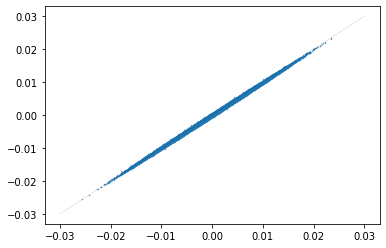

In [9]:
plt.scatter(xshear, yshear, s=0.1)
a = np.linspace(-0.03,0.03,100)
b = a
plt.plot(a,b,'-k', lw=0.1)

In [18]:
corsims = CorrelateTwoShears([x],[y])

In [19]:
corsims.correlation_in_bin('mp_e1',source=2, minz=0.8, maxz=0.9)

0.994681579897171

In [12]:
corsims.correlation_in_bin('mp_e1',source=2, minz=1.5, maxz=2)

0.9997769548284479

In [14]:
corsims.regression_in_bin('mp_e1', source=2, minz=1, maxz=1.5)

(0.9940408835604522, 9.538994784714987e-08)

In [12]:
xshear = srx.get_values('mp_e1', source=2, minz=1, maxz=1.5)

In [13]:
yshear = sry.get_values('mp_e1', source=2, minz=1, maxz=1.5)

In [14]:
xshear

array([-0.00339203,  0.00660518, -0.00108561, ...,  0.00398858,
       -0.00059953,  0.00803233])

In [15]:
yshear

array([-0.00287109,  0.00645723, -0.00106647, ...,  0.00387812,
       -0.00084866,  0.00757581])

In [49]:
_ = np.corrcoef(xshear,yshear)[0][1]

In [51]:
correlations =[]
correlations.append(_)

In [50]:
_

0.9997769548284479

garbage

In [23]:
minz = 1
maxz = 2
bins = 4
step = (maxz-minz)/bins
for b in range(bins):
    print(minz + b*step)

1.0
1.25
1.5
1.75


In [25]:
np.linspace(minz,maxz,bins+1)

array([1.  , 1.25, 1.5 , 1.75, 2.  ])